In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# =========================================
# ✅ PulseDB 혈압 예측 (수정 버전)
# =========================================

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout,
    BatchNormalization, concatenate
)
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

In [30]:
# =========================================
# 1️⃣ 데이터 로드
# =========================================
def load_signals(mat_path):
    signals = {'ppg': [], 'ecg': [], 'sbp': [], 'dbp': []}
    with h5py.File(mat_path, 'r') as f:
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        ecg_refs = f['Subj_Wins']['ECG_F'][0]
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]

        for i in range(len(ppg_refs)):
            try:
                ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
                ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
                sbp = float(f[sbp_refs[i]][()][0][0])
                dbp = float(f[dbp_refs[i]][()][0][0])

                # 단위 보정
                if sbp > 300 or dbp > 200:
                    sbp /= 10.0
                    dbp /= 10.0

                signals['ppg'].append(ppg)
                signals['ecg'].append(ecg)
                signals['sbp'].append(sbp)
                signals['dbp'].append(dbp)
            except:
                continue

    # numpy 변환
    for k in signals:
        signals[k] = np.array(signals[k], dtype=object)

    # ✅ 세그먼트 수 2000으로 고정
    n = len(signals['ppg'])
    if n > 2000:
        for k in signals:
            signals[k] = signals[k][:2000]
    elif n < 2000:
        if n == 0:
            raise ValueError("데이터가 존재하지 않습니다!")
        print(f"⚠️ {n}개만 존재 — 마지막 세그먼트를 반복하여 2000개로 맞춤")
        repeat_count = 2000 - n
        for k in signals:
            repeat_values = [signals[k][-1]] * repeat_count
            signals[k] = np.concatenate([signals[k], repeat_values])

    print(f"✅ 최종 세그먼트 수: {len(signals['ppg'])}")
    return signals

In [31]:
# =========================================
# 2️⃣ 전처리
# =========================================
def preprocess(signals, max_len=1000):
    n = len(signals['ppg'])
    X_ppg = np.zeros((n, max_len, 1))
    X_ecg = np.zeros((n, max_len, 1))

    for i in range(n):
        ppg = signals['ppg'][i][:max_len]
        ecg = signals['ecg'][i][:max_len]

        # 개별 정규화 + min-max
        ppg = (ppg - np.mean(ppg)) / (np.std(ppg) + 1e-6)
        ecg = (ecg - np.mean(ecg)) / (np.std(ecg) + 1e-6)
        ppg = (ppg - np.min(ppg)) / (np.max(ppg) - np.min(ppg) + 1e-6)
        ecg = (ecg - np.min(ecg)) / (np.max(ecg) - np.min(ecg) + 1e-6)

        X_ppg[i, :len(ppg), 0] = ppg
        X_ecg[i, :len(ecg), 0] = ecg

    y = np.array([[signals['sbp'][i], signals['dbp'][i]] for i in range(n)])
    return X_ppg, X_ecg, y

In [32]:
# =========================================
# 3️⃣ 모델 정의
# =========================================
def build_ppg_only(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        LSTM(64),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_ppg_ecg(input_shape):
    inp_ppg = Input(shape=input_shape)
    inp_ecg = Input(shape=input_shape)

    def branch(x):
        x = Conv1D(64, 5, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Conv1D(128, 5, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = LSTM(64)(x)
        x = Dense(64, activation='relu')(x)  # 추가
        return x

    feat_ppg = branch(inp_ppg)
    feat_ecg = branch(inp_ecg)

    merged = concatenate([feat_ppg, feat_ecg])
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.3)(x)
    out = Dense(2)(x)

    model = Model(inputs=[inp_ppg, inp_ecg], outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [34]:
# =========================================
# 4️⃣ 5-Fold 평가 (시간 순서)
# =========================================
def run_5fold(X_ppg, X_ecg, y, use_ecg=False):
    n = len(X_ppg) # 2000

    # 1. fold_size를 480이 아닌 400으로 수정
    fold_size = 400

    metrics = []

    for fold in range(5):
        start = fold * fold_size
        end = start + fold_size

        if end > n:
            break

        X_fold_ppg = X_ppg[start:end]
        y_fold = y[start:end]

        # 2. 훈련/검증/테스트 분할 비율을 320/40/40으로 수정
        X_train_ppg = X_fold_ppg[:320]
        X_val_ppg = X_fold_ppg[320:360]
        X_test_ppg = X_fold_ppg[360:]    # 360:400 과 동일

        y_train = y_fold[:320]
        y_val = y_fold[320:360]
        y_test = y_fold[360:]

        # ... (이하 라벨 정규화 부분은 동일) ...
        max_sbp, max_dbp = np.max(y_train[:,0]), np.max(y_train[:,1])
        y_train_scaled = y_train / [max_sbp, max_dbp]
        y_val_scaled = y_val / [max_sbp, max_dbp]
        y_test_scaled = y_test / [max_sbp, max_dbp] # y_test_scaled는 사실상 사용되지 않음

        if use_ecg:
            X_fold_ecg = X_ecg[start:end]

            # 3. ECG 데이터도 320/40/40으로 동일하게 분할
            X_train_ecg = X_fold_ecg[:320]
            X_val_ecg = X_fold_ecg[320:360]
            X_test_ecg = X_fold_ecg[360:]

            model = build_ppg_ecg((X_ppg.shape[1], 1))
            model.fit([X_train_ppg, X_train_ecg], y_train_scaled,
                      validation_data=([X_val_ppg, X_val_ecg], y_val_scaled),
                      epochs=60, batch_size=32, verbose=0)
            preds = model.predict([X_test_ppg, X_test_ecg], verbose=0)
        else:
            model = build_ppg_only((X_ppg.shape[1], 1))
            model.fit(X_train_ppg, y_train_scaled,
                      validation_data=(X_val_ppg, y_val_scaled),
                      epochs=60, batch_size=32, verbose=0)
            preds = model.predict(X_test_ppg, verbose=0)

        # Scale 복원
        preds_sbp = preds[:,0] * max_sbp
        preds_dbp = preds[:,1] * max_dbp
        y_true_sbp, y_true_dbp = y_test[:,0], y_test[:,1]

        mae_sbp = mean_absolute_error(y_true_sbp, preds_sbp)
        mae_dbp = mean_absolute_error(y_true_dbp, preds_dbp)
        rmse_sbp = np.sqrt(mean_squared_error(y_true_sbp, preds_sbp))
        rmse_dbp = np.sqrt(mean_squared_error(y_true_dbp, preds_dbp))
        metrics.append([mae_sbp, mae_dbp, rmse_sbp, rmse_dbp])

        print(f"Fold {fold+1}: MAE_SBP={mae_sbp:.3f}, MAE_DBP={mae_dbp:.3f}, RMSE_SBP={rmse_sbp:.3f}, RMSE_DBP={rmse_dbp:.3f}")

    metrics = np.array(metrics)
    print("\n=== 전체 평균 ± 표준편차 ===")
    print(f"MAE_SBP: {metrics[:,0].mean():.3f} ± {metrics[:,0].std():.3f}")
    print(f"MAE_DBP: {metrics[:,1].mean():.3f} ± {metrics[:,1].std():.3f}")
    print(f"RMSE_SBP: {metrics[:,2].mean():.3f} ± {metrics[:,2].std():.3f}")
    print(f"RMSE_DBP: {metrics[:,3].mean():.3f} ± {metrics[:,3].std():.3f}")

In [35]:
# =========================================
# 5️⃣ 혈압 그래프
# =========================================
def plot_bp(signals, subj):
    plt.figure(figsize=(12,4))
    plt.plot(signals['sbp'], 'r-', label='SBP')
    plt.plot(signals['dbp'], 'b-', label='DBP')
    plt.title(f"{subj} - Blood Pressure Trend", fontsize=13, fontweight='bold')
    plt.xlabel("Segment Index")
    plt.ylabel("Blood Pressure (mmHg)")
    plt.legend()
    plt.grid(True)
    plt.show()

✅ 최종 세그먼트 수: 2000


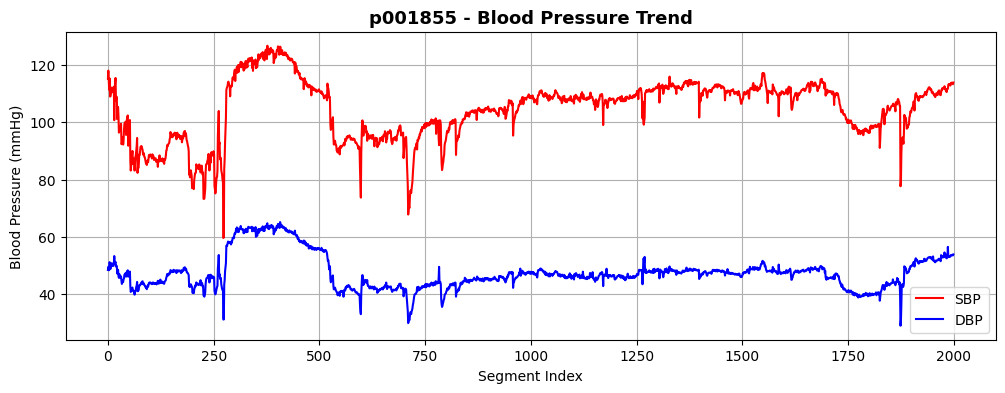


📊 [1/2] PPG Only 모델 결과
Fold 1: MAE_SBP=33.727, MAE_DBP=16.828, RMSE_SBP=33.992, RMSE_DBP=17.010
Fold 2: MAE_SBP=15.045, MAE_DBP=8.657, RMSE_SBP=16.649, RMSE_DBP=9.457
Fold 3: MAE_SBP=10.222, MAE_DBP=4.170, RMSE_SBP=10.592, RMSE_DBP=4.321
Fold 4: MAE_SBP=7.394, MAE_DBP=2.917, RMSE_SBP=7.672, RMSE_DBP=3.087
Fold 5: MAE_SBP=11.343, MAE_DBP=9.103, RMSE_SBP=11.641, RMSE_DBP=9.265

=== 전체 평균 ± 표준편차 ===
MAE_SBP: 15.546 ± 9.415
MAE_DBP: 8.335 ± 4.889
RMSE_SBP: 16.109 ± 9.399
RMSE_DBP: 8.628 ± 4.911

📊 [2/2] PPG+ECG 통합 모델 결과
Fold 1: MAE_SBP=23.784, MAE_DBP=13.922, RMSE_SBP=24.526, RMSE_DBP=14.246
Fold 2: MAE_SBP=8.600, MAE_DBP=3.866, RMSE_SBP=9.456, RMSE_DBP=4.372
Fold 3: MAE_SBP=2.742, MAE_DBP=1.116, RMSE_SBP=3.671, RMSE_DBP=1.473
Fold 4: MAE_SBP=4.201, MAE_DBP=1.418, RMSE_SBP=4.783, RMSE_DBP=1.812
Fold 5: MAE_SBP=8.984, MAE_DBP=4.836, RMSE_SBP=9.694, RMSE_DBP=5.201

=== 전체 평균 ± 표준편차 ===
MAE_SBP: 9.662 ± 7.466
MAE_DBP: 5.031 ± 4.665
RMSE_SBP: 10.426 ± 7.453
RMSE_DBP: 5.421 ± 4.640


In [36]:
# =========================================
# 6️⃣ 실행
# =========================================
mat_path = "/content/drive/MyDrive/data/p001855.mat"  # 본인 환자 경로
signals = load_signals(mat_path)
plot_bp(signals, "p001855")

X_ppg, X_ecg, y = preprocess(signals)

print("\n📊 [1/2] PPG Only 모델 결과")
run_5fold(X_ppg, X_ecg, y, use_ecg=False)

print("\n📊 [2/2] PPG+ECG 통합 모델 결과")
run_5fold(X_ppg, X_ecg, y, use_ecg=True)

✅ 최종 세그먼트 수: 2000
✅ 최종 세그먼트 수: 2000
📊 PPG Only 모델 결과 (p001855 → p004833)
MAE_SBP: 49.670, MAE_DBP: 17.870
RMSE_SBP: 50.224, RMSE_DBP: 18.388


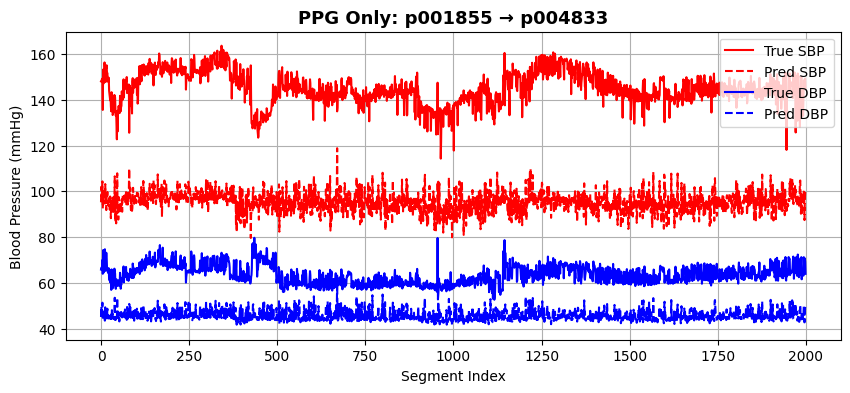

📊 PPG+ECG 모델 결과 (p001855 → p004833)
MAE_SBP: 51.588, MAE_DBP: 21.375
RMSE_SBP: 52.101, RMSE_DBP: 21.795


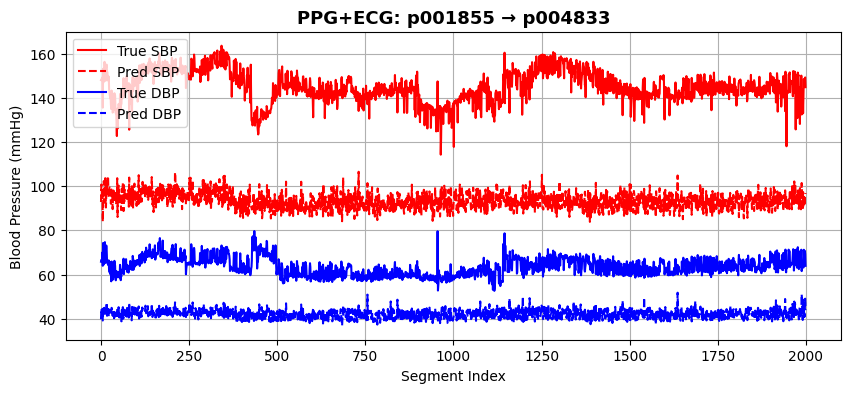

In [37]:
# =========================================
# ✅ p001855 학습 → p004833 테스트 (PPG Only & PPG+ECG)
# =========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

# =========================================
# 1️⃣ 학습용 데이터 로드 (p001855)
# =========================================
train_signals = load_signals("/content/drive/MyDrive/data/p001855.mat")
X_train_ppg, X_train_ecg, y_train = preprocess(train_signals)

# 라벨 정규화
max_sbp, max_dbp = np.max(y_train[:,0]), np.max(y_train[:,1])
y_train_scaled = y_train / [max_sbp, max_dbp]

# =========================================
# 2️⃣ 테스트용 데이터 로드 (p004833)
# =========================================
test_signals = load_signals("/content/drive/MyDrive/data/p004833.mat")
X_test_ppg, X_test_ecg, y_test = preprocess(test_signals)
y_test_scaled = y_test / [max_sbp, max_dbp]  # 학습 기준으로 스케일링

# =========================================
# 3️⃣ 모델 학습 및 테스트 함수
# =========================================
def train_and_test_ppg():
    # 모델 학습 (PPG Only)
    model = build_ppg_only((X_train_ppg.shape[1], 1))
    model.fit(X_train_ppg, y_train_scaled, epochs=40, batch_size=32, verbose=0)

    # 테스트
    preds = model.predict(X_test_ppg, verbose=0)
    preds_sbp = preds[:,0] * max_sbp
    preds_dbp = preds[:,1] * max_dbp

    # 평가
    mae_sbp = mean_absolute_error(y_test[:,0], preds_sbp)
    mae_dbp = mean_absolute_error(y_test[:,1], preds_dbp)
    rmse_sbp = np.sqrt(mean_squared_error(y_test[:,0], preds_sbp))
    rmse_dbp = np.sqrt(mean_squared_error(y_test[:,1], preds_dbp))

    print("📊 PPG Only 모델 결과 (p001855 → p004833)")
    print(f"MAE_SBP: {mae_sbp:.3f}, MAE_DBP: {mae_dbp:.3f}")
    print(f"RMSE_SBP: {rmse_sbp:.3f}, RMSE_DBP: {rmse_dbp:.3f}")

    # 그래프
    plt.figure(figsize=(10,4))
    plt.plot(y_test[:,0], 'r-', label='True SBP')
    plt.plot(preds_sbp, 'r--', label='Pred SBP')
    plt.plot(y_test[:,1], 'b-', label='True DBP')
    plt.plot(preds_dbp, 'b--', label='Pred DBP')
    plt.title("PPG Only: p001855 → p004833", fontsize=13, fontweight='bold')
    plt.xlabel("Segment Index")
    plt.ylabel("Blood Pressure (mmHg)")
    plt.legend()
    plt.grid(True)
    plt.show()

def train_and_test_ppg_ecg():
    # 모델 학습 (PPG + ECG)
    model = build_ppg_ecg((X_train_ppg.shape[1], 1))
    model.fit([X_train_ppg, X_train_ecg], y_train_scaled, epochs=40, batch_size=32, verbose=0)

    # 테스트
    preds = model.predict([X_test_ppg, X_test_ecg], verbose=0)
    preds_sbp = preds[:,0] * max_sbp
    preds_dbp = preds[:,1] * max_dbp

    # 평가
    mae_sbp = mean_absolute_error(y_test[:,0], preds_sbp)
    mae_dbp = mean_absolute_error(y_test[:,1], preds_dbp)
    rmse_sbp = np.sqrt(mean_squared_error(y_test[:,0], preds_sbp))
    rmse_dbp = np.sqrt(mean_squared_error(y_test[:,1], preds_dbp))

    print("📊 PPG+ECG 모델 결과 (p001855 → p004833)")
    print(f"MAE_SBP: {mae_sbp:.3f}, MAE_DBP: {mae_dbp:.3f}")
    print(f"RMSE_SBP: {rmse_sbp:.3f}, RMSE_DBP: {rmse_dbp:.3f}")

    # 그래프
    plt.figure(figsize=(10,4))
    plt.plot(y_test[:,0], 'r-', label='True SBP')
    plt.plot(preds_sbp, 'r--', label='Pred SBP')
    plt.plot(y_test[:,1], 'b-', label='True DBP')
    plt.plot(preds_dbp, 'b--', label='Pred DBP')
    plt.title("PPG+ECG: p001855 → p004833", fontsize=13, fontweight='bold')
    plt.xlabel("Segment Index")
    plt.ylabel("Blood Pressure (mmHg)")
    plt.legend()
    plt.grid(True)
    plt.show()

# =========================================
# 4️⃣ 실행
# =========================================
train_and_test_ppg()
train_and_test_ppg_ecg()